In [7]:
# [Cell 1] 라이브러리 설치 및 임포트
!pip install gymnasium stable-baselines3[extra] pandas numpy yfinance matplotlib shimmy

import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from datetime import datetime

In [8]:
# [Cell 2] 데이터 전처리 및 환경 클래스 정의
# --- 1. 데이터 전처리 함수 ---
def prepare_data():
    print("데이터 다운로드 및 전처리 시작...")

    # 1. 데이터 다운로드 (2022-11-01부터)
    start_date = "2022-11-01"
    end_date = datetime.today().strftime('%Y-%m-%d')

    # auto_adjust=False로 설정
    soxl = yf.download("SOXL", start=start_date, end=end_date, progress=False, auto_adjust=False)
    jepq = yf.download("JEPQ", start=start_date, end=end_date, progress=False, auto_adjust=False)
    spy = yf.download("SPY", start=start_date, end=end_date, progress=False, auto_adjust=False)

    # 1차원 변환 함수 (Series.squeeze() 활용)
    def get_close_series(df):
        if 'Adj Close' in df.columns:
            series = df['Adj Close']
        elif 'Close' in df.columns:
            series = df['Close']
        else:
            series = df.iloc[:, 0]
        return series.squeeze()

    df = pd.DataFrame({
        'soxl_price': get_close_series(soxl),
        'jepq_price': get_close_series(jepq),
        'spy_price': get_close_series(spy)
    }).dropna()

    # 기술적 지표 계산
    df['soxl_ma20'] = df['soxl_price'].rolling(window=20).mean()
    df['soxl_std20'] = df['soxl_price'].rolling(window=20).std()

    # Z-Score (핵심)
    df['soxl_z_score'] = (df['soxl_price'] - df['soxl_ma20']) / (df['soxl_std20'] + 1e-9)

    # RSI
    delta = df['soxl_price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-9)
    df['soxl_rsi'] = 100 - (100 / (1 + rs))

    df = df.dropna().reset_index(drop=True)
    print(f"전처리 완료. 데이터 개수: {len(df)}일")
    return df

# --- 2. 환경 클래스 정의 ---
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.MAX_STEPS = len(df) - 1

        # Action Space: 0:Hold, 1:BuySOXL, 2:SellSOXL(10%), 3:SellSOXL(50%), 4:SwitchToSOXL
        self.action_space = spaces.Discrete(5)

        # Observation Space: 9개 차원
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(9,), dtype=np.float32)

        self.INITIAL_CASH = 70000
        self.init_jepq_cash = 6600

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0

        price_soxl = self.df.loc[self.current_step, 'soxl_price']
        price_jepq = self.df.loc[self.current_step, 'jepq_price']

        # 초기 자산 배분
        self.jepq_qty = int(self.init_jepq_cash // price_jepq)
        cost_jepq = self.jepq_qty * price_jepq

        self.cash = self.INITIAL_CASH - cost_jepq
        self.soxl_qty = 0
        self.soxl_avg_price = 0

        self.history = {'net_worth': [], 'reward': []}
        return self._next_observation(), {}

    def _next_observation(self):
        obs_data = self.df.loc[self.current_step]
        soxl_return = 0.0
        if self.soxl_qty > 0:
            soxl_return = (obs_data['soxl_price'] - self.soxl_avg_price) / self.soxl_avg_price

        net_worth = self.cash + (self.soxl_qty * obs_data['soxl_price']) + (self.jepq_qty * obs_data['jepq_price'])

        obs = np.array([
            self.cash, self.soxl_qty, self.jepq_qty, soxl_return, net_worth,
            obs_data['soxl_price'], obs_data['jepq_price'],
            obs_data['soxl_z_score'], obs_data['soxl_rsi']
        ], dtype=np.float32)
        return obs

    def step(self, action):
        self.current_step += 1
        current_data = self.df.loc[self.current_step]
        price_soxl = current_data['soxl_price']
        price_jepq = current_data['jepq_price']

        # [환경 규칙] 월 적립 & 배당 재투자
        if self.current_step % 20 == 0:
            # 1. 월 적립 $1000
            invest_amt = 1000
            if self.cash >= invest_amt:
                buy_qty = int(invest_amt // price_jepq)
                if buy_qty > 0:
                    self.jepq_qty += buy_qty
                    self.cash -= (buy_qty * price_jepq)

            # 2. 배당 재투자 (연 10% 가정 -> 월 0.83%)
            dividend_amt = (self.jepq_qty * price_jepq) * 0.0083
            reinvest_qty = int(dividend_amt // price_jepq)
            self.jepq_qty += reinvest_qty
            self.cash += (dividend_amt - (reinvest_qty * price_jepq))

        # [에이전트 행동]
        if action == 1: # Buy SOXL
            invest_amt = 1000
            if self.cash >= invest_amt:
                buy_qty = int(invest_amt // price_soxl)
                if buy_qty > 0:
                    total_cost = (self.soxl_qty * self.soxl_avg_price) + (buy_qty * price_soxl)
                    self.soxl_qty += buy_qty
                    self.soxl_avg_price = total_cost / self.soxl_qty
                    self.cash -= (buy_qty * price_soxl)
        elif action == 2 and self.soxl_qty > 0: # Sell 10% -> JEPQ
            sell_qty = int(self.soxl_qty * 0.1)
            if sell_qty > 0:
                proceeds = sell_qty * price_soxl
                self.soxl_qty -= sell_qty
                self.cash += proceeds
                jepq_buy_qty = int(proceeds // price_jepq)
                self.jepq_qty += jepq_buy_qty
                self.cash -= (jepq_buy_qty * price_jepq)
        elif action == 3 and self.soxl_qty > 0: # Sell 50% -> JEPQ
            sell_qty = int(self.soxl_qty * 0.5)
            if sell_qty > 0:
                proceeds = sell_qty * price_soxl
                self.soxl_qty -= sell_qty
                self.cash += proceeds
                jepq_buy_qty = int(proceeds // price_jepq)
                self.jepq_qty += jepq_buy_qty
                self.cash -= (jepq_buy_qty * price_jepq)
        elif action == 4 and self.jepq_qty > 0: # Switch to SOXL (JEPQ 10% 매도)
             sell_qty = int(self.jepq_qty * 0.1)
             if sell_qty > 0:
                self.jepq_qty -= sell_qty
                self.cash += (sell_qty * price_jepq)

        # 보상 계산
        prev_net_worth = self.history['net_worth'][-1] if len(self.history['net_worth']) > 0 else self.INITIAL_CASH
        curr_net_worth = self.cash + (self.soxl_qty * price_soxl) + (self.jepq_qty * price_jepq)
        reward = (curr_net_worth - prev_net_worth) / prev_net_worth

        self.history['net_worth'].append(curr_net_worth)
        self.history['reward'].append(reward)
        done = self.current_step >= self.MAX_STEPS - 1

        return self._next_observation(), reward, done, False, {}

In [9]:
# [Cell 3] 데이터 준비 및 PPO 학습 실행

# 1. 데이터 준비
df = prepare_data()

# 2. 환경 생성
env = DummyVecEnv([lambda: StockTradingEnv(df)])

# 3. 모델 생성 및 학습
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, seed=42)
print("학습 시작...")
model.learn(total_timesteps=100000) # 시간 소요됨
print("학습 완료!")

# 4. 모델 저장 (선택)
model.save("ppo_stock_agent")

데이터 다운로드 및 전처리 시작...
전처리 완료. 데이터 개수: 758일
Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


학습 시작...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------
| time/              |      |
|    fps             | 1031 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 775         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013234861 |
|    clip_fraction        | 0.0638      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | -0.974      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0307      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00456    |
|    value_loss           | 0.00395     |
-----------------------------------------
----------------------------------

시뮬레이션 진행 중...


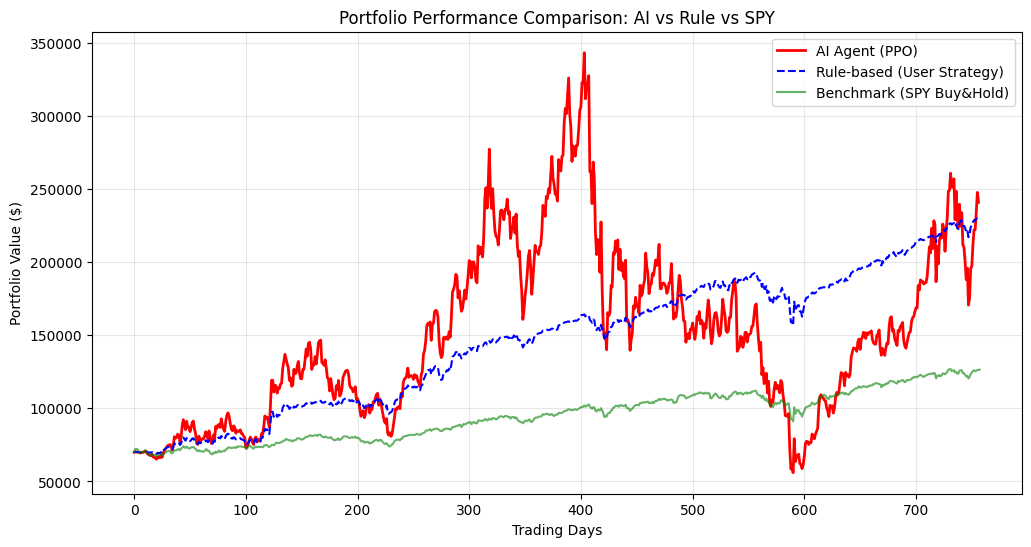

Strategy        | Return (%)   | Sharpe Ratio | MDD (%)     
------------------------------------------------------------
AI Agent        |     244.26% |     0.9106 |     -83.71%
Rule-based      |     228.92% |     2.0730 |     -18.79%
Benchmark       |      80.78% |     1.3396 |     -18.76%


In [11]:
# [Cell 4] 결과 시각화 및 분석
import matplotlib.pyplot as plt
import numpy as np

def calculate_metrics(portfolio_values):
    """수익률, 샤프지수, MDD를 계산하는 함수"""
    portfolio_values = np.array(portfolio_values)

    # 1. 총 수익률
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_value) / initial_value * 100

    # 2. 일간 수익률 및 샤프 지수
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    # 연율화 (252거래일 기준), 무위험이자율 0% 가정
    sharpe_ratio = np.mean(daily_returns) / (np.std(daily_returns) + 1e-9) * np.sqrt(252)

    # 3. MDD (Maximum Drawdown)
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - peak) / peak
    max_drawdown = np.min(drawdown) * 100

    return total_return, sharpe_ratio, max_drawdown

def run_simulation(env, model=None, strategy_type='ai'):
    """
    환경에서 시뮬레이션을 돌리고 포트폴리오 가치 변화를 기록합니다.
    """
    obs, _ = env.reset()
    done = False

    # 초기 자산 가치를 obs(상태값)에서 가져옵니다.
    # obs 구조: [0:Cash, 1:SOXL_Qty, 2:JEPQ_Qty, 3:SOXL_Ret, 4:Net_Worth, ...]
    # 따라서 obs[4]가 현재 총 자산 가치입니다.
    portfolio_history = [obs[4]]

    while not done:
        if strategy_type == 'ai':
            # AI 모델이 판단
            action, _ = model.predict(obs, deterministic=True)

        elif strategy_type == 'rule':
            # 사용자 정의 규칙 (Rule-based)
            # obs 구조: [0:Cash, 1:SOXL_Qty, 2:JEPQ_Qty, 3:SOXL_Ret, 4:Net, 5:SOXL_P, 6:JEPQ_P, 7:Z_Score, 8:RSI]
            soxl_return = obs[3]
            z_score = obs[7]

            # 규칙 1: SOXL 1표준편차 하락(Z < -1.0) & 현금 있으면 -> 매수 (Action 1)
            if z_score < -1.0:
                action = 1
            # 규칙 2: SOXL 수익률 75% 이상 -> 일부 매도 후 JEPQ 전환 (Action 2)
            elif soxl_return > 0.75:
                action = 2
            # 그 외: 관망 (Action 0)
            else:
                action = 0

        # 환경에서 행동 실행
        obs, reward, done, _, _ = env.step(action)
        # step 실행 후에는 history에 값이 추가되므로 여기서 가져옵니다.
        portfolio_history.append(env.history['net_worth'][-1])

    return portfolio_history

# --- 시뮬레이션 실행 ---
print("시뮬레이션 진행 중...")

# 1. AI (PPO) 에이전트 실행
# DummyVecEnv로 감싸지 않은 순수 환경 객체를 사용합니다.
eval_env = StockTradingEnv(df)
ai_history = run_simulation(eval_env, model, strategy_type='ai')

# 2. Rule-based (사용자 전략) 실행
eval_env = StockTradingEnv(df)
rule_history = run_simulation(eval_env, strategy_type='rule')

# 3. Benchmark (SPY 단순 보유)
spy_prices = df['spy_price'].values
initial_spy_qty = 70000 / spy_prices[0]
spy_history = spy_prices * initial_spy_qty

# --- 결과 시각화 ---
plt.figure(figsize=(12, 6))
plt.plot(ai_history, label='AI Agent (PPO)', color='red', linewidth=2)
plt.plot(rule_history, label='Rule-based (User Strategy)', color='blue', linestyle='--')
plt.plot(spy_history, label='Benchmark (SPY Buy&Hold)', color='green', alpha=0.6)

plt.title('Portfolio Performance Comparison: AI vs Rule vs SPY')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 성과 지표 출력 ---
ai_res = calculate_metrics(ai_history)
rule_res = calculate_metrics(rule_history)
spy_res = calculate_metrics(spy_history)

print(f"{'Strategy':<15} | {'Return (%)':<12} | {'Sharpe Ratio':<12} | {'MDD (%)':<12}")
print("-" * 60)
print(f"{'AI Agent':<15} | {ai_res[0]:10.2f}% | {ai_res[1]:10.4f} | {ai_res[2]:10.2f}%")
print(f"{'Rule-based':<15} | {rule_res[0]:10.2f}% | {rule_res[1]:10.4f} | {rule_res[2]:10.2f}%")
print(f"{'Benchmark':<15} | {spy_res[0]:10.2f}% | {spy_res[1]:10.4f} | {spy_res[2]:10.2f}%")